## dataload

In [62]:
import mlflow
import mlflow.lightgbm
from datetime import datetime
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
import pandas as pd
import os
import random
import warnings
warnings.filterwarnings('ignore')
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
import numpy as np
from utils import custom_train_test_split, lgbm_predict, post_slack, title2filename

SEED=13
## 1. 데이터 로딩
data_dir = '/opt/ml/input/data' # 경로
after_fe_path = os.path.join(data_dir, 'base_lgbm2.pkl')
df = pd.read_pickle(after_fe_path)

train_df = df[df.kind=='train']
train, valid = custom_train_test_split(train_df, ratio=0.7, seed=SEED) # 훈련데이터 split
test = df[df.kind=='test'] # 테스트 데이터
train2 = test[test.answerCode!=-1] # 테스트데이터 마지막 제출 2번쨰꺼까지 훈련데이터로 사용
train = pd.concat([train,train2]) # 훈련데이터 병합
train.shape, valid.shape, test.shape

x_train = train.drop('answerCode',axis=1)
y_train = train[['answerCode']]

x_valid = valid.drop('answerCode',axis=1)
y_valid = valid[['answerCode']]
x_train.shape, y_train.shape, x_valid.shape, y_valid.shape

((1845539, 40), (1974, 40), (260114, 40))

((1845539, 39), (1845539, 1), (1974, 39), (1974, 1))

## Hyper Parameter 설정

In [63]:
# Hyper parameter 설정
params = {
#     "max_depth": 8,  # 8,
#     "min_data_in_leaf": 1000,
    # "feature_fraction": 0.6,  # 0.8,
#     "bagging_fraction": 0.75,
    # "max_cat_group": 64,
    "objective": "binary",
#     "boosting": "gbdt",  # dart
#     "learning_rate": 0.01,  # 0.01,
    # "bagging_freq": 5,
    "seed": 42,
    # "max_bin": 50,
#     "num_leaves": 80,  # 40,
#     "metric": "auc",
}

## big category base

In [77]:
### 피처 설정
# 사용할 Feature 설정
FEATS = ['uidIdx',
         'assIdx',
         'testIdx',
         'KnowledgeTag',
         'user_correct_answer',
         'user_total_answer',
         'big_category',
         'mid_category',
         'problem_num',
         'month','day','dayname','hour',
         'user_acc',
         'test_mean',
         'test_sum',
         'test_std',
         'tag_std',
         'tag_mean',
         'tag_sum',
         'solvesec_3600',
         'time_category',
         'solvesec_cumsum',
         'solvecumsum_category',
         'big_category_acc',
         'big_category_std',
         'big_category_cumconut'
        ]

cat_feats = ['uidIdx','assIdx','testIdx','KnowledgeTag','big_category','mid_category',
             'problem_num','dayname','month','time_category','solvecumsum_category']
cat_feats_idx = [i for i,e in enumerate(FEATS) if e in cat_feats]

### 학습 및 예측

date = datetime.now().strftime('%m/%d %a')
title=f"🌈({date})[LGBM Base] 피처: {len(FEATS)}개"
using_feats=", ".join(FEATS)
desc=f"사용된 피처({len(FEATS)})\n{using_feats}"
cat_feats_idx, title, desc

mlflow.lightgbm.autolog()
lgb_x_train = lgb.Dataset(x_train[FEATS], y_train)
lgb_x_valid = lgb.Dataset(x_valid[FEATS], y_valid)

with mlflow.start_run(run_name=title, description=desc) as run:
    model = lgb.train(
        params, 
        lgb_x_train,
        valid_sets=[lgb_x_valid],
        verbose_eval=100,
        num_boost_round=3200,
        categorical_feature=cat_feats_idx,
        early_stopping_rounds=200,
    )

    preds = model.predict(x_valid[FEATS])
    acc = accuracy_score(y_valid, np.where(preds >= 0.5, 1, 0))
    auc = roc_auc_score(y_valid, preds)
    print(f'VALID AUC : {auc} ACC : {acc}\n')
    mlflow.log_metric("VAL AUC",auc)
    mlflow.log_metric("VAL Set SEED",SEED)
    model_run_id=run.info.run_id
    post_slack("done")
    print(f"{model_run_id=}")
    file_name = title2filename(title)
    lgbm_predict(test, model, FEATS, f'{file_name}.csv')

([0, 1, 2, 3, 6, 7, 8, 9, 11, 21, 23],
 '🌈(12/02 Fri)[LGBM Base] 피처: 27개',
 '사용된 피처(27)\nuidIdx, assIdx, testIdx, KnowledgeTag, user_correct_answer, user_total_answer, big_category, mid_category, problem_num, month, day, dayname, hour, user_acc, test_mean, test_sum, test_std, tag_std, tag_mean, tag_sum, solvesec_3600, time_category, solvesec_cumsum, solvecumsum_category, big_category_acc, big_category_std, big_category_cumconut')

[LightGBM] [Info] Number of positive: 1208276, number of negative: 637263
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.077163 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 19316
[LightGBM] [Info] Number of data points in the train set: 1845539, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.654701 -> initscore=0.639767
[LightGBM] [Info] Start training from score 0.639767
Training until validation scores don't improve for 200 rounds
[100]	valid_0's binary_logloss: 0.560243
[200]	valid_0's binary_logloss: 0.551904
[300]	valid_0's binary_logloss: 0.549396
[400]	valid_0's binary_logloss: 0.547937
[500]	valid_0's binary_logloss: 0.546311
[600]	valid_0's binary_logloss: 0.544856
[700]	valid_0's binary_logloss: 0.544792
[800]	valid_0's binary_logloss: 0.544924
Early stopping, best iteration is:
[672]	vali

In [ ]:
### 제출 mlflow 등록
# 제출시
LB_AUC=
run_id = model_run_id
mlflow.start_run(run_id=run_id)
run = mlflow.active_run()
print("Active run_id: {}".format(run.info.run_id))
mlflow.log_metric("LB AUC",LB_AUC)
mlflow.end_run()

## big category per user

In [78]:
### 피처 설정
# 사용할 Feature 설정
FEATS = ['uidIdx',
         'assIdx',
         'testIdx',
         'KnowledgeTag',
         'user_correct_answer',
         'user_total_answer',
         'big_category',
         'mid_category',
         'problem_num',
         'month','day','dayname','hour',
         'user_acc',
         'test_mean',
         'test_sum',
         'test_std',
         'tag_std',
         'tag_mean',
         'tag_sum',
         'solvesec_3600',
         'time_category',
         'solvesec_cumsum',
         'solvecumsum_category',
         'big_category_acc',
         'big_category_std',
         'big_category_user_acc',
         'big_category_user_std',
         'big_category_cumconut'
        ]

cat_feats = ['uidIdx','assIdx','testIdx','KnowledgeTag','big_category','mid_category',
             'problem_num','dayname','month','time_category','solvecumsum_category']
cat_feats_idx = [i for i,e in enumerate(FEATS) if e in cat_feats]

### 학습 및 예측

date = datetime.now().strftime('%m/%d %a')
title=f"🌈({date})[LGBM Base user별] 피처: {len(FEATS)}개"
using_feats=", ".join(FEATS)
desc=f"사용된 피처({len(FEATS)})\n{using_feats}"
cat_feats_idx, title, desc

mlflow.lightgbm.autolog()
lgb_x_train = lgb.Dataset(x_train[FEATS], y_train)
lgb_x_valid = lgb.Dataset(x_valid[FEATS], y_valid)

with mlflow.start_run(run_name=title, description=desc) as run:
    model2 = lgb.train(
        params, 
        lgb_x_train,
        valid_sets=[lgb_x_valid],
        verbose_eval=100,
        num_boost_round=3200,
        categorical_feature=cat_feats_idx,
        early_stopping_rounds=200,
    )

    preds2 = model2.predict(x_valid[FEATS])
    acc = accuracy_score(y_valid, np.where(preds2 >= 0.5, 1, 0))
    auc = roc_auc_score(y_valid, preds2)
    print(f'VALID AUC : {auc} ACC : {acc}\n')
    mlflow.log_metric("VAL AUC",auc)
    mlflow.log_metric("VAL Set SEED",SEED)
    model2_run_id=run.info.run_id
    post_slack("done")
    print(f"{model2_run_id=}")
    file_name = title2filename(title)
    lgbm_predict(test, model2, FEATS, f'{file_name}.csv')

([0, 1, 2, 3, 6, 7, 8, 9, 11, 21, 23],
 '🌈(12/02 Fri)[LGBM Base user별] 피처: 29개',
 '사용된 피처(29)\nuidIdx, assIdx, testIdx, KnowledgeTag, user_correct_answer, user_total_answer, big_category, mid_category, problem_num, month, day, dayname, hour, user_acc, test_mean, test_sum, test_std, tag_std, tag_mean, tag_sum, solvesec_3600, time_category, solvesec_cumsum, solvecumsum_category, big_category_acc, big_category_std, big_category_user_acc, big_category_user_std, big_category_cumconut')

[LightGBM] [Info] Number of positive: 1208276, number of negative: 637263
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.112924 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 19826
[LightGBM] [Info] Number of data points in the train set: 1845539, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.654701 -> initscore=0.639767
[LightGBM] [Info] Start training from score 0.639767
Training until validation scores don't improve for 200 rounds
[100]	valid_0's binary_logloss: 0.513222
[200]	valid_0's binary_logloss: 0.503496
[300]	valid_0's binary_logloss: 0.500693
[400]	valid_0's binary_logloss: 0.500737
[500]	valid_0's binary_logloss: 0.500584
[600]	valid_0's binary_logloss: 0.501405
Early stopping, best iteration is:
[493]	valid_0's binary_logloss: 0.500322
VALID AUC : 0.8333806514261263 ACC : 0.759371833839

In [ ]:
### 제출 mlflow 등록
# 제출시
LB_AUC=
run_id = model_run_id
mlflow.start_run(run_id=run_id)
run = mlflow.active_run()
print("Active run_id: {}".format(run.info.run_id))
mlflow.log_metric("LB AUC",LB_AUC)
mlflow.end_run()

In [84]:
max(preds2)

0.9992968251793795

<AxesSubplot:ylabel='Density'>

<AxesSubplot:ylabel='Density'>

<AxesSubplot:ylabel='Density'>

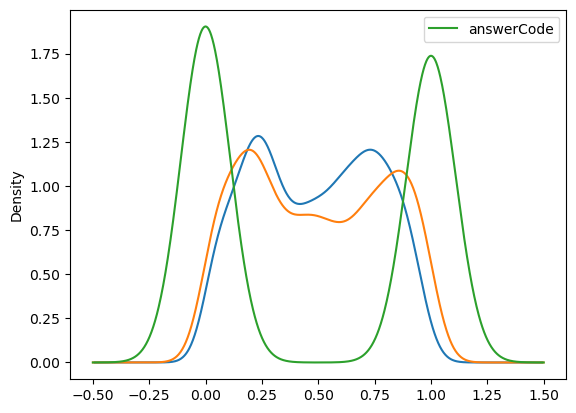

In [97]:
pd.Series(preds).plot(kind='kde')
pd.Series(preds2).plot(kind='kde')
y_valid.answerCode.plot(kind='kde', legend=True)

<AxesSubplot:ylabel='Frequency'>

<AxesSubplot:ylabel='Frequency'>

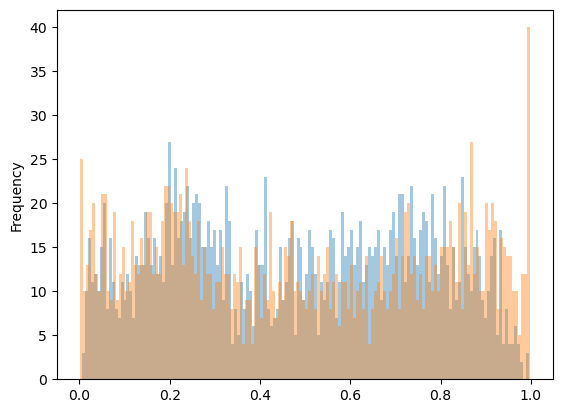

In [115]:
pd.Series(preds).plot(kind='hist', bins=150, alpha=0.4)
pd.Series(preds2).plot(kind='hist', bins=150, alpha=0.4)

<AxesSubplot:>

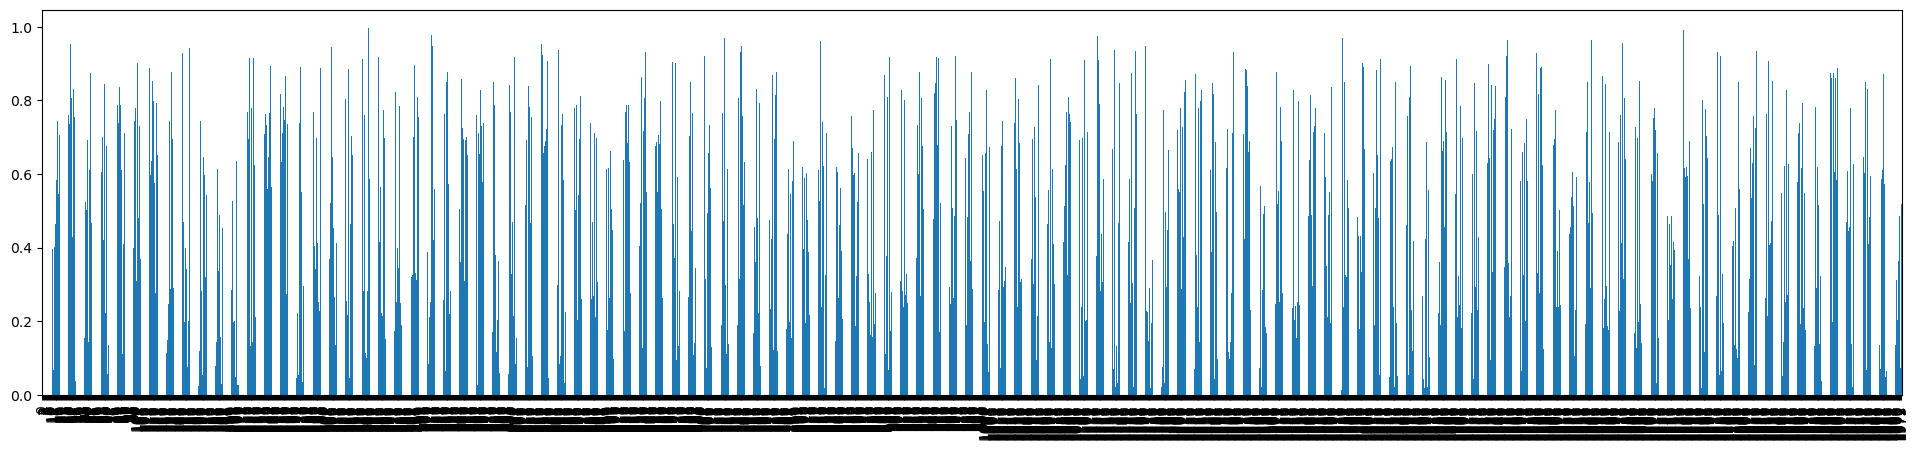

In [112]:
pd.Series(preds).plot(figsize=(24,5),kind='bar')

<AxesSubplot:>

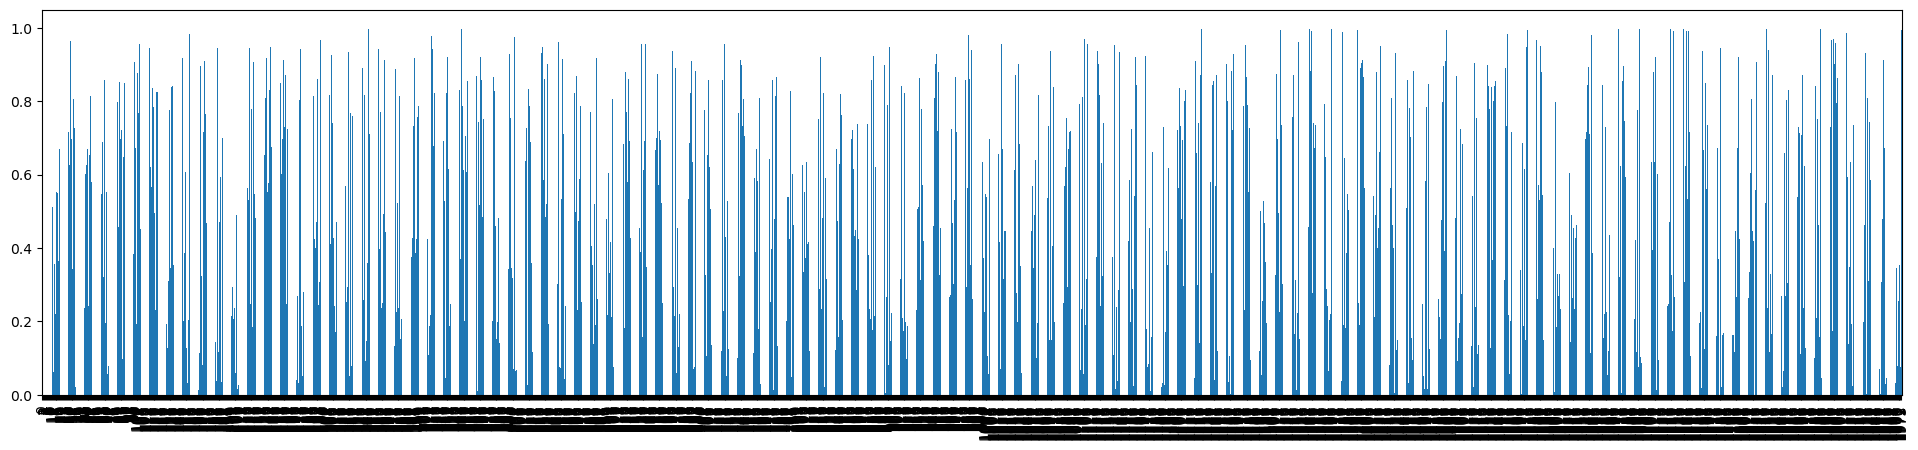

In [113]:
pd.Series(preds2).plot(figsize=(24,5),kind='bar')

<AxesSubplot:>

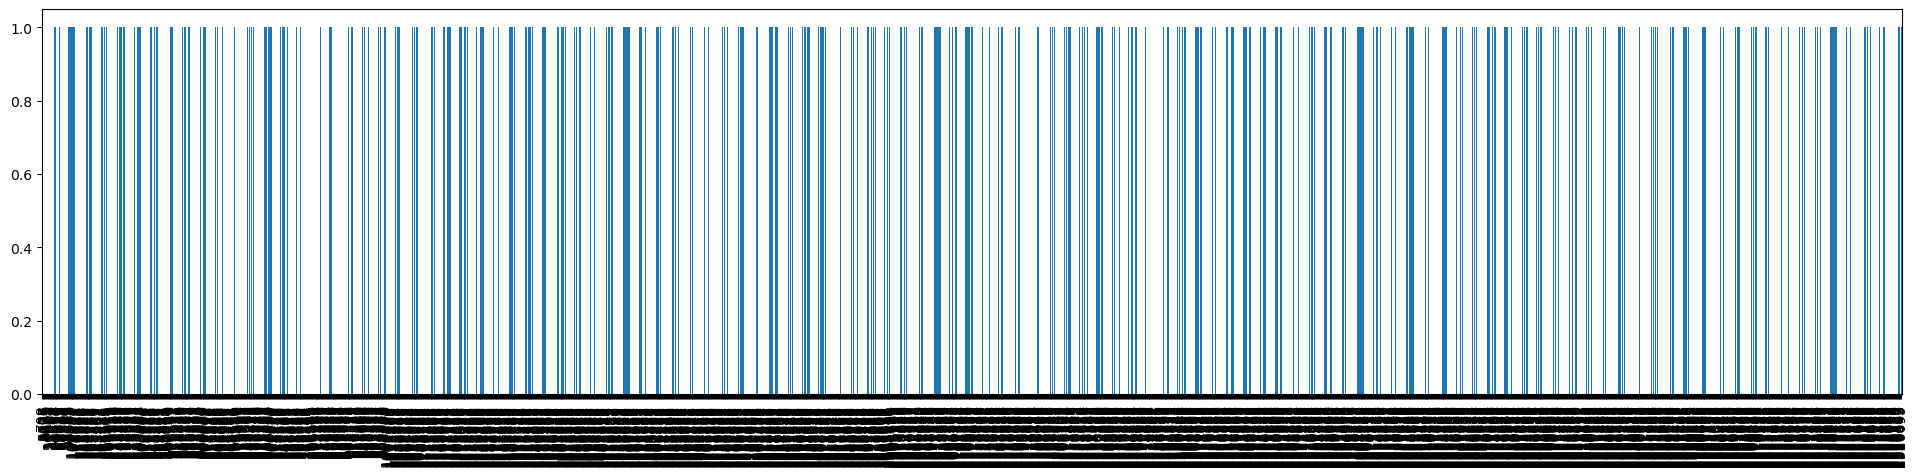

In [114]:
y_valid.answerCode.plot(figsize=(24,5),kind='bar')